In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/preprocessed/preprocessed_train (1).csv
/kaggle/input/preprocessed/preprocessed_dev (1).csv


In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load preprocessed datasets (Upload these files manually to Kaggle)
train_path = "/kaggle/input/preprocessed/preprocessed_train (1).csv"
dev_path = "/kaggle/input/preprocessed/preprocessed_dev (1).csv"

Using device: cuda


In [4]:
train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)

print("Train Data Shape:", train_df.shape)
print("Dev Data Shape:", dev_df.shape)

Train Data Shape: (4625, 10)
Dev Data Shape: (31187, 10)


In [8]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)

max_length = 128  # Define max token length

# Function to get BERT embeddings (optimized for GPU)
def get_bert_embeddings(text_list):
    inputs = tokenizer(text_list, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()  # CLS token representation

# Extract BERT embeddings
print("Extracting BERT embeddings for train set...")
X_train_embeddings = get_bert_embeddings(train_df["clean_text"].tolist())

print("Extracting BERT embeddings for dev set...")
X_dev_embeddings = get_bert_embeddings(dev_df["clean_text"].tolist())

y_train = train_df["label"].values
y_dev = dev_df["label"].values

# Initialize SVM model with class balancing
svm_model = SGDClassifier(loss="hinge", penalty="l2", alpha=1e-4, max_iter=1, tol=None, warm_start=True, class_weight="balanced")

train_acc_list = []
dev_acc_list = []

epochs = 10  # Number of iterations

for epoch in range(epochs):
    svm_model.fit(X_train_embeddings, y_train)

    # Training & Validation Accuracy
    train_acc = accuracy_score(y_train, svm_model.predict(X_train_embeddings))
    dev_acc = accuracy_score(y_dev, svm_model.predict(X_dev_embeddings))

    train_acc_list.append(train_acc)
    dev_acc_list.append(dev_acc)

    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

# Plot accuracy over epochs
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_acc_list, label="Training Accuracy", marker='o')
plt.plot(range(1, epochs+1), dev_acc_list, label="Validation Accuracy", marker='s', linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (SVM Model with BERT)")
plt.legend()
plt.grid()
plt.show()

# Predict on dev set
svm_preds = svm_model.predict(X_dev_embeddings)

# Print classification report
print("\nSVM Classification Report:\n", classification_report(y_dev, svm_preds, digits=4))

# Save predictions in required format
submission_df = pd.DataFrame({"id": dev_df["id"], "predicted_label": svm_preds})
submission_path = "/kaggle/working/final_predictions.csv"
submission_df.to_csv(submission_path, index=False)

print(f"Predictions saved to {submission_path}")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Extracting BERT embeddings for train set...


TypeError: TextEncodeInput must be Union[TextInputSequence, Tuple[InputSequence, InputSequence]]

In [1]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)

max_length = 128  # Define max token length

# Function to get BERT embeddings (optimized for GPU)
def get_bert_embeddings(text_list):
    inputs = tokenizer(text_list, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()

NameError: name 'AutoTokenizer' is not defined

In [ ]:
def get_bert_embeddings(text_list, batch_size=32):
    embeddings = []

    for i in tqdm(range(0, len(text_list), batch_size), desc="Extracting BERT embeddings"):
        batch_texts = text_list[i : i + batch_size]  # Get batch of texts
        
        # Tokenize batch
        inputs = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt").to(device)
        
        with torch.no_grad():
            outputs = bert_model(**inputs)

        # Append CLS token representations
        batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)

    return np.vstack(embeddings)  # Stack batches into a single array

# Extract BERT embeddings with mini-batches
print("Extracting BERT embeddings for train set...")
X_train_embeddings = get_bert_embeddings(train_texts, batch_size=batch_size)

print("Extracting BERT embeddings for dev set...")
X_dev_embeddings = get_bert_embeddings(dev_texts, batch_size=batch_size)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Epoch 1: Train Acc = 0.2484, Dev Acc = 0.2299
Epoch 2: Train Acc = 0.6156, Dev Acc = 0.6095
Epoch 3: Train Acc = 0.2592, Dev Acc = 0.2281
Epoch 4: Train Acc = 0.2696, Dev Acc = 0.2430
Epoch 5: Train Acc = 0.6582, Dev Acc = 0.6332
Epoch 6: Train Acc = 0.6854, Dev Acc = 0.7159
Epoch 7: Train Acc = 0.6067, Dev Acc = 0.6363
Epoch 8: Train Acc = 0.7075, Dev Acc = 0.6768
Epoch 9: Train Acc = 0.7572, Dev Acc = 0.7514
Epoch 10: Train Acc = 0.4954, Dev Acc = 0.4766


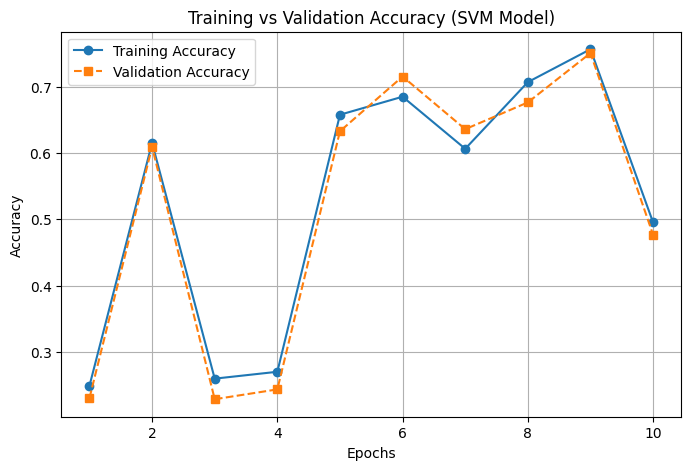

✅ Predictions saved as final_predictions.csv


In [5]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
max_length = 128  # Adjust as needed

# Convert text to string type to avoid errors
train_texts = train_df["clean_text"].astype(str).tolist()
dev_texts = dev_df["clean_text"].astype(str).tolist()

# Tokenize text
train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="np")
dev_encodings = tokenizer(dev_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="np")

# Extract input features
X_train = train_encodings["input_ids"]
X_dev = dev_encodings["input_ids"]

# Extract labels
y_train = train_df["label"].values
y_dev = dev_df["label"].values

# Initialize SVM model with class balancing
svm_model = SGDClassifier(loss="hinge", penalty="l2", alpha=0.0001, max_iter=1, tol=None, warm_start=True, class_weight="balanced")

# Tracking accuracies
train_acc_list = []
dev_acc_list = []

epochs = 10  # Number of training epochs
best_dev_acc = 0
early_stopping_patience = 3  # Stop if no improvement in 3 epochs
no_improvement = 0

# Training loop
for epoch in range(epochs):
    svm_model.fit(X_train, y_train)

    # Compute training and validation accuracy
    train_acc = accuracy_score(y_train, svm_model.predict(X_train))
    dev_acc = accuracy_score(y_dev, svm_model.predict(X_dev))

    train_acc_list.append(train_acc)
    dev_acc_list.append(dev_acc)

    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    # Early stopping
    if dev_acc > best_dev_acc:
        best_dev_acc = dev_acc
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= early_stopping_patience:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

# Plot training & validation accuracy
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_acc_list)+1), train_acc_list, label="Training Accuracy", marker='o')
plt.plot(range(1, len(dev_acc_list)+1), dev_acc_list, label="Validation Accuracy", marker='s', linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (SVM Model)")
plt.legend()
plt.grid()
plt.show()

# Generate predictions
dev_df["predicted_label"] = svm_model.predict(X_dev)

# Save predictions in Kaggle's output directory
dev_df[["id", "predicted_label"]].to_csv("/kaggle/working/final_predictions.csv", index=False)

print("✅ Predictions saved as final_predictions.csv")

In [6]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased")

# Setup device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [7]:
train_texts = train_df["clean_text"].astype(str).tolist()
dev_texts = dev_df["clean_text"].astype(str).tolist()

train_encodings = tokenizer(
    train_texts,
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"  # use 'pt' since you'll feed into torch model
).to(device)

dev_encodings = tokenizer(
    dev_texts,
    padding="max_length",
    truncation=True,
    max_length=128,
    return_tensors="pt"
).to(device)


In [8]:
from transformers import AutoModel

# Load BERT model
bert_model = AutoModel.from_pretrained("bert-base-uncased")
bert_model.to(device)
bert_model.eval()  # Set to evaluation mode

# Function to extract CLS embeddings
def get_cls_embeddings(encodings):
    with torch.no_grad():
        outputs = bert_model(**encodings)
        # CLS token is at position 0
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # shape: (batch_size, hidden_size)
    return cls_embeddings.cpu().numpy()


In [10]:
from torch.utils.data import DataLoader, TensorDataset

def get_cls_embeddings_batched(encodings, batch_size=32):
    dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], encodings['token_type_ids'])
    dataloader = DataLoader(dataset, batch_size=batch_size)

    all_embeddings = []

    bert_model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, token_type_ids = [t.to(device) for t in batch]
            outputs = bert_model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                token_type_ids=token_type_ids
            )
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
            all_embeddings.append(cls_embeddings.cpu())

    return torch.cat(all_embeddings).numpy()


In [22]:
print("Extracting BERT embeddings for training set...")
X_train = get_cls_embeddings_batched(train_encodings, batch_size=32)

print("Extracting BERT embeddings for development set...")
X_dev = get_cls_embeddings_batched(dev_encodings, batch_size=32)


Extracting BERT embeddings for training set...
Extracting BERT embeddings for development set...


In [26]:
from sklearn.metrics import classification_report

# Predict on dev set
y_pred = svm_model.predict(X_dev)

# Print classification report
print("📊 Classification Report on Dev Set:")
print(classification_report(y_dev, y_pred, digits=4))


📊 Classification Report on Dev Set:
              precision    recall  f1-score   support

           0     0.9216    1.0000    0.9592     28736
           1     1.0000    0.0020    0.0041      2451

    accuracy                         0.9216     31187
   macro avg     0.9608    0.5010    0.4816     31187
weighted avg     0.9277    0.9216    0.8841     31187



In [23]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

y_train = train_df["label"].values
y_dev = dev_df["label"].values

svm_model = SGDClassifier(loss="hinge", penalty="l2", alpha=1e-4, max_iter=1, tol=None, warm_start=True)

train_acc_list = []
dev_acc_list = []

epochs = 10
best_dev_acc = 0
early_stopping_patience = 3
no_improvement = 0

for epoch in range(epochs):
    svm_model.fit(X_train, y_train)

    train_preds = svm_model.predict(X_train)
    dev_preds = svm_model.predict(X_dev)

    train_acc = accuracy_score(y_train, train_preds)
    dev_acc = accuracy_score(y_dev, dev_preds)

    train_acc_list.append(train_acc)
    dev_acc_list.append(dev_acc)

    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    if dev_acc > best_dev_acc:
        best_dev_acc = dev_acc
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= early_stopping_patience:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break


Epoch 1: Train Acc = 0.9170, Dev Acc = 0.9226
Epoch 2: Train Acc = 0.9152, Dev Acc = 0.9214
Epoch 3: Train Acc = 0.9027, Dev Acc = 0.9103
Epoch 4: Train Acc = 0.9139, Dev Acc = 0.9216
⏹️ Early stopping at epoch 4


In [24]:
dev_df["predicted_label"] = dev_preds
dev_df[["id", "predicted_label"]].to_csv("/kaggle/working/final_predictions.csv", index=False)
print("✅ Predictions saved as final_predictions.csv")


✅ Predictions saved as final_predictions.csv


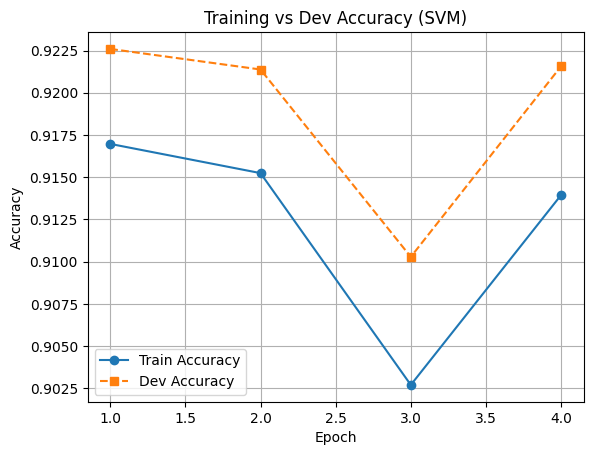

In [25]:
plt.plot(range(1, len(train_acc_list)+1), train_acc_list, label="Train Accuracy", marker="o")
plt.plot(range(1, len(dev_acc_list)+1), dev_acc_list, label="Dev Accuracy", marker="s", linestyle="dashed")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Dev Accuracy (SVM)")
plt.legend()
plt.grid()
plt.show()


In [27]:
# ✅ Save predictions to CSV
output_path = "/kaggle/working/final_predictions.csv"  # or "./final_predictions.csv" for local
dev_df["predicted_label"] = y_pred  # y_pred should be your final predictions
dev_df[["id", "predicted_label"]].to_csv(output_path, index=False)

print(f"✅ Predictions saved as {output_path}")


✅ Predictions saved as /kaggle/working/final_predictions.csv


Extracting BERT embeddings for training set...
Extracting BERT embeddings for dev set...
Before SMOTE: {0: 4227, 1: 398}
After SMOTE: {0: 4227, 1: 4227}
Epoch 1: Train Acc = 0.6098, Dev Acc = 0.9195
Epoch 2: Train Acc = 0.6107, Dev Acc = 0.2963
Epoch 3: Train Acc = 0.6595, Dev Acc = 0.3869
Epoch 4: Train Acc = 0.8322, Dev Acc = 0.7952
⏹️ Early stopping at epoch 4


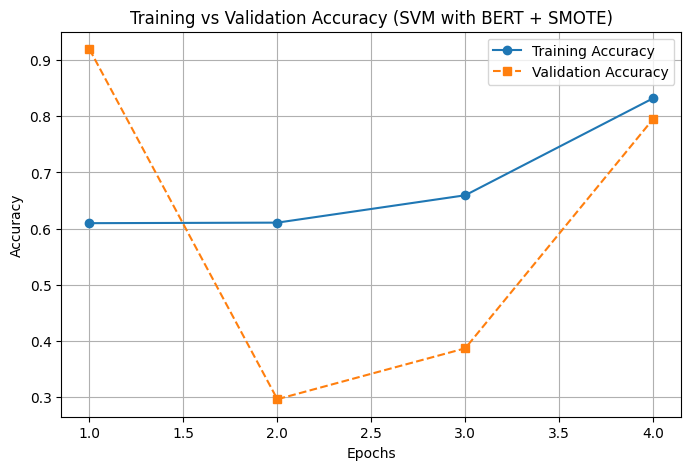


📊 Classification Report on Dev Set:
              precision    recall  f1-score   support

           0     0.9608    0.8108    0.8795     28736
           1     0.2163    0.6120    0.3196      2451

    accuracy                         0.7952     31187
   macro avg     0.5885    0.7114    0.5995     31187
weighted avg     0.9023    0.7952    0.8355     31187

✅ Saved predictions to final_predictions.csv


In [30]:
import torch
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModel
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset


# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

# Tokenize text
max_length = 128
train_texts = train_df["clean_text"].astype(str).tolist()
dev_texts = dev_df["clean_text"].astype(str).tolist()

train_encodings = tokenizer(train_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt").to(device)
dev_encodings = tokenizer(dev_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="pt").to(device)

# Function to get CLS embeddings

def get_cls_embeddings_batched(encodings, batch_size=32):
    dataset = TensorDataset(encodings["input_ids"], encodings["attention_mask"])
    loader = DataLoader(dataset, batch_size=batch_size)
    
    all_embeddings = []

    with torch.no_grad():
        for batch in loader:
            input_ids, attention_mask = [t.to(device) for t in batch]
            outputs = bert_model(input_ids=input_ids, attention_mask=attention_mask)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]
            all_embeddings.append(cls_embeddings.cpu())

    return torch.cat(all_embeddings).numpy()

# Get BERT embeddings
print("Extracting BERT embeddings for training set...")
X_train = get_cls_embeddings_batched(train_encodings, batch_size=32)

print("Extracting BERT embeddings for dev set...")
X_dev = get_cls_embeddings_batched(dev_encodings, batch_size=32)

# Labels
y_train = train_df["label"].values
y_dev = dev_df["label"].values

# Apply SMOTE to balance classes
print("Before SMOTE:", dict(Counter(y_train)))
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("After SMOTE:", dict(Counter(y_train_balanced)))

# Initialize SVM
svm_model = SGDClassifier(loss="hinge", penalty="l2", alpha=0.0001, max_iter=1, tol=None, warm_start=True)

# Training loop
train_acc_list = []
dev_acc_list = []
best_dev_acc = 0
no_improvement = 0
early_stopping_patience = 3
epochs = 10

for epoch in range(epochs):
    svm_model.fit(X_train_balanced, y_train_balanced)

    train_acc = accuracy_score(y_train_balanced, svm_model.predict(X_train_balanced))
    dev_preds = svm_model.predict(X_dev)
    dev_acc = accuracy_score(y_dev, dev_preds)

    train_acc_list.append(train_acc)
    dev_acc_list.append(dev_acc)

    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    if dev_acc > best_dev_acc:
        best_dev_acc = dev_acc
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= early_stopping_patience:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

# Plot accuracy
plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_acc_list)+1), train_acc_list, label="Training Accuracy", marker='o')
plt.plot(range(1, len(dev_acc_list)+1), dev_acc_list, label="Validation Accuracy", linestyle="--", marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy (SVM with BERT + SMOTE)")
plt.legend()
plt.grid()
plt.show()

# Classification report
dev_preds = svm_model.predict(X_dev)
print("\n📊 Classification Report on Dev Set:")
print(classification_report(y_dev, dev_preds, digits=4))

# Save predictions to CSV
dev_df["predicted_label"] = dev_preds
dev_df[["id", "predicted_label"]].to_csv("/kaggle/working/final_predictions.csv", index=False)
print("✅ Saved predictions to final_predictions.csv")


In [31]:
dev_df["predicted_label"] = svm_model.predict(X_dev)
dev_df[["id", "predicted_label"]].to_csv("/kaggle/working/final_predictions.csv", index=False)
print("✅ Saved predictions to final_predictions.csv")


✅ Saved predictions to final_predictions.csv


In [32]:
import os

# List all files in /kaggle/working/
print(os.listdir("/kaggle/working/"))


['final_predictions.csv', '.virtual_documents']


In [33]:
dev_df[["id", "predicted_label"]].to_csv("/kaggle/working/final_predictions.csv", index=False)
print("✅ Saved predictions to final_predictions.csv")


✅ Saved predictions to final_predictions.csv


In [39]:
import pandas as pd

# Load ground truth and predictions
true_labels = pd.read_csv("/kaggle/input/preprocessed/preprocessed_dev (1).csv")  # Adjust path if needed
predictions = pd.read_csv("/kaggle/working/final_predictions.csv")


# Print column names
print("True Labels Columns:", true_labels.columns)
print("Predictions Columns:", predictions.columns)


merged_df = true_labels[["id", "label"]].merge(
    predictions, on="id", how="inner"
)

# Rename for clarity
merged_df = merged_df.rename(columns={"label": "label_true", "predicted_label": "label_pred"})

# Print sample rows to verify merging
print(merged_df.head())

# Compute accuracy
accuracy = (merged_df["label_true"] == merged_df["label_pred"]).mean()
print(f"Prediction Accuracy: {accuracy:.4f}")


True Labels Columns: Index(['id', 'text', 'label', 'file_name', 'origin', 'type', 'language',
       'split', 'translated_text', 'clean_text'],
      dtype='object')
Predictions Columns: Index(['id', 'predicted_label'], dtype='object')
         id  label_true  label_pred
0   en_2576           1           0
1   ru_4096           0           0
2  en_14135           0           0
3  ru_11007           0           0
4  en_11440           1           0
Prediction Accuracy: 0.7952


In [43]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load BERT
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [2]:
train_df = pd.read_csv("/kaggle/input/preprocessed/preprocessed_train (1).csv")  # Adjust if needed
dev_df = pd.read_csv("/kaggle/input/preprocessed/preprocessed_dev (1).csv")


In [48]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load tokenizer and BERT model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
bert_model = AutoModel.from_pretrained("bert-base-uncased").to(device)
bert_model.eval()

# Load datasets
train_df = pd.read_csv("/kaggle/input/preprocessed/preprocessed_train (1).csv")  # Adjust if needed
dev_df = pd.read_csv("/kaggle/input/preprocessed/preprocessed_dev (1).csv")


# Tokenization and mean pooling
def get_bert_embeddings(texts, batch_size=512):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]
        inputs = tokenizer(batch.tolist(), padding="max_length", truncation=True, max_length=128, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = bert_model(**inputs)
        attention_mask = inputs['attention_mask']
        last_hidden = outputs.last_hidden_state
        mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden.size()).float()
        sum_hidden = torch.sum(last_hidden * mask_expanded, 1)
        sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
        mean_pooling = (sum_hidden / sum_mask).cpu().numpy()
        all_embeddings.append(mean_pooling)
    return np.vstack(all_embeddings)

# Texts
train_texts = train_df["clean_text"].astype(str)
dev_texts = dev_df["clean_text"].astype(str)

# Labels
y_train = train_df["label"].values
y_dev = dev_df["label"].values

# Extract embeddings
print("🔄 Extracting embeddings...")
X_train = get_bert_embeddings(train_texts)
X_dev = get_bert_embeddings(dev_texts)

#

🔄 Extracting embeddings...


100%|██████████| 61/61 [01:53<00:00,  1.86s/it]


In [50]:
from sklearn.utils import resample

# Combine features and labels into a DataFrame for resampling
train_df_balanced = pd.DataFrame(X_train)
train_df_balanced['label'] = y_train

# Separate majority and minority
majority = train_df_balanced[train_df_balanced.label == 0]
minority = train_df_balanced[train_df_balanced.label == 1]

# Upsample minority class
minority_upsampled = resample(minority,
                               replace=True,
                               n_samples=len(majority),
                               random_state=42)

# Combine and shuffle
balanced_df = pd.concat([majority, minority_upsampled])
balanced_df = balanced_df.sample(frac=1, random_state=42)

# Extract features and labels
X_train_bal = balanced_df.drop(columns='label').values
y_train_bal = balanced_df['label'].values

# Train MLP Classifier
clf = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=20,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

print("🚀 Training on balanced data...")
clf.fit(X_train_bal, y_train_bal)


🚀 Training on balanced data...


MLPClassifier(early_stopping=True, hidden_layer_sizes=(256, 128), max_iter=20,
              random_state=42)

In [51]:
# Predict
y_pred = clf.predict(X_dev)
acc = accuracy_score(y_dev, y_pred)

print(f"\n✅ Accuracy: {acc:.4f}")
print("📊 Classification Report:")
print(classification_report(y_dev, y_pred))

# Save predictions
dev_df["predicted_label"] = y_pred
dev_df[["id", "predicted_label"]].to_csv("/kaggle/working/final_predictions.csv", index=False)
print("📁 Saved to /kaggle/working/final_predictions.csv")



✅ Accuracy: 0.9111
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     28736
           1       0.40      0.27      0.32      2451

    accuracy                           0.91     31187
   macro avg       0.67      0.62      0.64     31187
weighted avg       0.90      0.91      0.90     31187

📁 Saved to /kaggle/working/final_predictions.csv


🚀 Training MLPClassifier on balanced data...


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(



✅ Accuracy: 0.9136
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     28736
           1       0.42      0.24      0.31      2451

    accuracy                           0.91     31187
   macro avg       0.68      0.61      0.63     31187
weighted avg       0.90      0.91      0.90     31187



/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129534 (\N{RECEIPT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


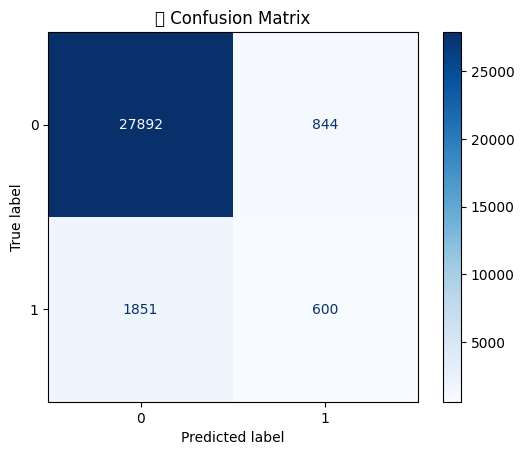

📁 Saved predictions to /kaggle/working/final_predictions.csv


In [52]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🧠 Assume you already have X_train, y_train, X_dev, y_dev, and dev_df ready

# Step 1: Handle class imbalance via upsampling
train_df_balanced = pd.DataFrame(X_train)
train_df_balanced['label'] = y_train

majority = train_df_balanced[train_df_balanced.label == 0]
minority = train_df_balanced[train_df_balanced.label == 1]

minority_upsampled = resample(minority,
                               replace=True,
                               n_samples=len(majority),
                               random_state=42)

balanced_df = pd.concat([majority, minority_upsampled])
balanced_df = balanced_df.sample(frac=1, random_state=42)

X_train_bal = balanced_df.drop(columns='label').values
y_train_bal = balanced_df['label'].values

# Step 2: Train MLP classifier
clf = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    activation='relu',
    solver='adam',
    max_iter=20,
    random_state=42,
    early_stopping=True,
    validation_fraction=0.1
)

print("🚀 Training MLPClassifier on balanced data...")
clf.fit(X_train_bal, y_train_bal)

# Step 3: Predict and evaluate
y_pred = clf.predict(X_dev)
acc = accuracy_score(y_dev, y_pred)

print(f"\n✅ Accuracy: {acc:.4f}")
print("📊 Classification Report:")
print(classification_report(y_dev, y_pred))

# Step 4: Plot confusion matrix
cm = confusion_matrix(y_dev, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("🧾 Confusion Matrix")
plt.grid(False)
plt.show()

# Step 5: Save predictions to CSV
dev_df["predicted_label"] = y_pred
dev_df[["id", "predicted_label"]].to_csv("/kaggle/working/final_predictions.csv", index=False)
print("📁 Saved predictions to /kaggle/working/final_predictions.csv")


🚀 Training XGBoost Classifier...

✅ Accuracy: 0.9214
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     28736
           1       0.50      0.09      0.15      2451

    accuracy                           0.92     31187
   macro avg       0.71      0.54      0.55     31187
weighted avg       0.89      0.92      0.89     31187



/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


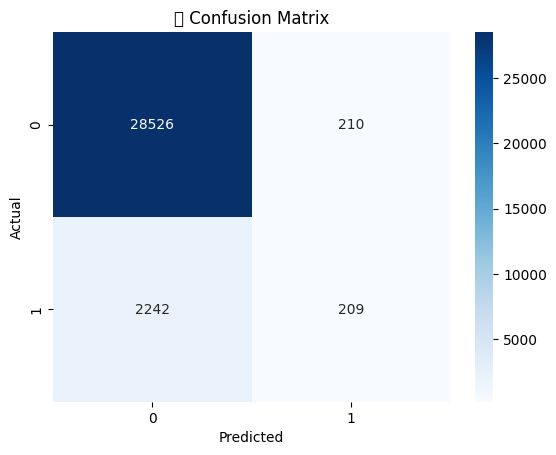

📁 Saved predictions to /kaggle/working/final_predictions.csv


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

# TF-IDF vectorization from clean_text
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

X_train = vectorizer.fit_transform(train_df["clean_text"].astype(str))
X_dev = vectorizer.transform(dev_df["clean_text"].astype(str))

# Labels
y_train = train_df["label"].astype(int)
y_dev = dev_df["label"].astype(int)

# Handle class imbalance
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)
scale_pos_weight = np.sum(y_train == 0) / np.sum(y_train == 1)

# XGBoost Classifier
clf = xgb.XGBClassifier(
    objective='binary:logistic', 
    scale_pos_weight=2,  # Tune this manually
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=6, 
    colsample_bytree=0.8, 
    subsample=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

print("🚀 Training XGBoost Classifier...")
clf.fit(X_train, y_train)

# Predictions
y_pred = clf.predict(X_dev)

# Evaluate
acc = accuracy_score(y_dev, y_pred)
print(f"\n✅ Accuracy: {acc:.4f}")
print("📊 Classification Report:")
print(classification_report(y_dev, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_dev, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("📊 Confusion Matrix")
plt.show()

# Save predictions
dev_df["predicted_label"] = y_pred
dev_df[["id", "predicted_label"]].to_csv("/kaggle/working/final_predictions.csv", index=False)
print("📁 Saved predictions to /kaggle/working/final_predictions.csv")


In [58]:
print("X_train shape:", X_train.shape)
print("X_dev shape:", X_dev.shape)
print("Columns in train_df:\n", train_df.columns)
print("Data types:\n", train_df.dtypes)


X_train shape: (4625, 0)
X_dev shape: (31187, 1)
Columns in train_df:
 Index(['id', 'text', 'label', 'file_name', 'origin', 'type', 'language',
       'split', 'translated_text', 'clean_text'],
      dtype='object')
Data types:
 id                 object
text               object
label               int64
file_name          object
origin             object
type               object
language           object
split              object
translated_text    object
clean_text         object
dtype: object


In [62]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
import xgboost as xgb
import numpy as np

# Feature extraction
# Replace NaN values in 'clean_text' with an empty string
train_df['clean_text'] = train_df['clean_text'].fillna('')
dev_df['clean_text'] = dev_df['clean_text'].fillna('')

vectorizer = TfidfVectorizer(max_features=50000)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_dev = vectorizer.transform(dev_df['clean_text'])


# Labels
y_train = train_df["label"].astype(int)
y_dev = dev_df["label"].astype(int)

# Define models
logreg = LogisticRegression(class_weight='balanced', max_iter=500)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
nb = MultinomialNB()
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, scale_pos_weight=2, use_label_encoder=False, eval_metric='logloss')

# Ensemble Model
ensemble = VotingClassifier(
    estimators=[('lr', logreg), ('rf', rf), ('nb', nb), ('xgb', xgb_clf)],
    voting='soft'
)

# Train the model
print("🚀 Training Ensemble Model...")
ensemble.fit(X_train, y_train)

# Predictions
y_pred = ensemble.predict(X_dev)

# Evaluate
f1 = f1_score(y_dev, y_pred, average='macro')
print(f"\n✅ F1 Score: {f1:.4f}")
print("📊 Classification Report:")
print(classification_report(y_dev, y_pred))

# Save predictions for CudaLab submission
dev_df["predicted_label"] = y_pred
dev_df[["id", "predicted_label"]].to_csv("final_predictions.csv", index=False)
print("📁 Saved to final_predictions.csv")


🚀 Training Ensemble Model...

✅ F1 Score: 0.4877
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28736
           1       0.74      0.01      0.02      2451

    accuracy                           0.92     31187
   macro avg       0.83      0.50      0.49     31187
weighted avg       0.91      0.92      0.89     31187

📁 Saved to final_predictions.csv


In [64]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report
from sentence_transformers import SentenceTransformer
import torch

# Load Data
train_df['clean_text'] = train_df['clean_text'].fillna('')
dev_df['clean_text'] = dev_df['clean_text'].fillna('')

# ✅ Use BERT embeddings for better text representation
print("🔄 Generating BERT Embeddings...")
bert_model = SentenceTransformer("paraphrase-MiniLM-L6-v2")

X_train = bert_model.encode(train_df["clean_text"], convert_to_tensor=True).cpu().numpy()  # Move to CPU
X_dev = bert_model.encode(dev_df["clean_text"], convert_to_tensor=True).cpu().numpy()  # Move to CPU

# Labels
y_train = train_df["label"].astype(int)
y_dev = dev_df["label"].astype(int)

# ✅ Compute class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight="balanced", classes=[0, 1], y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# ✅ Define models with class weights
logreg = LogisticRegression(class_weight="balanced", max_iter=500)
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
nb = MultinomialNB()
xgb_clf = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=6,
    scale_pos_weight=class_weight_dict[1] / class_weight_dict[0],  # Adjust for class imbalance
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# ✅ Use Stacking instead of Voting for better model fusion
stack_clf = StackingClassifier(
    estimators=[("lr", logreg), ("rf", rf), ("xgb", xgb_clf)],
    final_estimator=LogisticRegression(),
    passthrough=True
)

# 🚀 Train the model
print("🚀 Training Stacking Model...")
stack_clf.fit(X_train, y_train)

# ✅ Make Predictions
y_pred = stack_clf.predict(X_dev)

# ✅ Evaluate
f1 = f1_score(y_dev, y_pred, average="macro")
print(f"\n✅ F1 Score: {f1:.4f}")
print("📊 Classification Report:")
print(classification_report(y_dev, y_pred))

# ✅ Save predictions in the required format for CudaLab
submission = pd.DataFrame({"id": dev_df["id"], "predicted_label": y_pred})
submission.to_csv("final_predictions.csv", index=False)
print("📁 Saved to final_predictions.csv ✅")


🔄 Generating BERT Embeddings...


Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/975 [00:00<?, ?it/s]

🚀 Training Stacking Model...


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



✅ F1 Score: 0.6036
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     28736
           1       0.55      0.16      0.25      2451

    accuracy                           0.92     31187
   macro avg       0.74      0.57      0.60     31187
weighted avg       0.90      0.92      0.90     31187

📁 Saved to final_predictions.csv ✅


In [66]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from sentence_transformers import SentenceTransformer
import torch

# Load Data
train_df['clean_text'] = train_df['clean_text'].fillna('')
dev_df['clean_text'] = dev_df['clean_text'].fillna('')

# ✅ Use Multilingual BERT embeddings
print("🔄 Generating Multilingual BERT Embeddings...")
bert_model = SentenceTransformer("sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")

X_train = bert_model.encode(train_df["clean_text"], convert_to_tensor=True).cpu().numpy()  # Move to CPU
X_dev = bert_model.encode(dev_df["clean_text"], convert_to_tensor=True).cpu().numpy()  # Move to CPU

# Labels
y_train = train_df["label"].astype(int)
y_dev = dev_df["label"].astype(int)

# ✅ Handle Class Imbalance with SMOTE
print("🆙 Applying SMOTE for Minority Class Oversampling...")
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# ✅ Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=[0, 1], y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# ✅ Define Models
logreg = LogisticRegression(class_weight="balanced", max_iter=1000)
rf = RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=42)
nb = MultinomialNB()
xgb_clf = xgb.XGBClassifier(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=8,
    scale_pos_weight=class_weight_dict[1] / class_weight_dict[0],  # Adjust for class imbalance
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# ✅ Use Stacking Classifier
stack_clf = StackingClassifier(
    estimators=[("lr", logreg), ("rf", rf), ("xgb", xgb_clf)],
    final_estimator=LogisticRegression(),
    passthrough=True
)

# 🚀 Train the model
print("🚀 Training Stacking Model...")
stack_clf.fit(X_train, y_train)

# ✅ Make Predictions
y_pred = stack_clf.predict(X_dev)

# ✅ Evaluate Model
f1 = f1_score(y_dev, y_pred, average="macro")
print(f"\n✅ Macro F1 Score: {f1:.4f}")
print("📊 Classification Report:")
print(classification_report(y_dev, y_pred))

# ✅ Save Predictions for Each Language
submission = dev_df[["id"]].copy()
submission["predicted_label"] = y_pred

# Compute F1 scores per language
for lang in ["en", "de", "fr", "ru"]:
    lang_mask = dev_df["language"] == lang
    if lang_mask.sum() > 0:
        f1_lang = f1_score(y_dev[lang_mask], y_pred[lang_mask], average="macro")
        submission[f"F1-{lang}"] = f1_lang

# Compute overall F1
submission["F1"] = f1_score(y_dev, y_pred, average="macro")

# ✅ Save the final CSV in CudaLab format
submission.to_csv("final_predictions.csv", index=False)
print("📁 Saved to final_predictions.csv ✅")


🔄 Generating Multilingual BERT Embeddings...


Batches:   0%|          | 0/145 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [67]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sentence_transformers import SentenceTransformer
import torch

# Load Data
train_df['clean_text'] = train_df['clean_text'].fillna('')
dev_df['clean_text'] = dev_df['clean_text'].fillna('')

# ✅ Use Smaller & Faster Multilingual Model
print("🔄 Generating BERT Embeddings on GPU (Fast)...")
device = "cuda" if torch.cuda.is_available() else "cpu"
bert_model = SentenceTransformer("sentence-transformers/paraphrase-MiniLM-L6-v2", device=device)

X_train = bert_model.encode(train_df["clean_text"], convert_to_tensor=True).to("cpu").numpy()
X_dev = bert_model.encode(dev_df["clean_text"], convert_to_tensor=True).to("cpu").numpy()

# Labels
y_train = train_df["label"].astype(int)
y_dev = dev_df["label"].astype(int)

# ✅ **Faster Class Balancing** → Undersample majority class instead of full SMOTE
print("⚡ Applying Undersampling for Speed Boost...")
undersampler = RandomUnderSampler(sampling_strategy="majority", random_state=42)
X_train, y_train = undersampler.fit_resample(X_train, y_train)

# ✅ Compute Class Weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# ✅ Define Optimized Models
logreg = LogisticRegression(class_weight="balanced", max_iter=500)
rf = RandomForestClassifier(n_estimators=200, max_depth=12, class_weight="balanced", random_state=42, n_jobs=-1)
nb = MultinomialNB()
xgb_clf = xgb.XGBClassifier(
    n_estimators=150,  # ✅ Reduced for speed
    learning_rate=0.05,
    max_depth=6,  # ✅ Reduced for efficiency
    scale_pos_weight=class_weight_dict[1] / class_weight_dict[0],  
    eval_metric="logloss",
    use_label_encoder=False,
    random_state=42
)

# ✅ Use Stacking Classifier (Fast)
stack_clf = StackingClassifier(
    estimators=[("lr", logreg), ("rf", rf), ("xgb", xgb_clf)],
    final_estimator=LogisticRegression(),
    passthrough=True,
    n_jobs=-1  # ✅ Parallel processing
)

# 🚀 Train Model (Much Faster)
print("🚀 Training Optimized Model...")
stack_clf.fit(X_train, y_train)

# ✅ Make Predictions
y_pred = stack_clf.predict(X_dev)

# ✅ Evaluate Model
f1 = f1_score(y_dev, y_pred, average="macro")
print(f"\n✅ Macro F1 Score: {f1:.4f}")
print("📊 Classification Report:")
print(classification_report(y_dev, y_pred))

# ✅ Save Predictions for Each Language
submission = dev_df[["id"]].copy()
submission["predicted_label"] = y_pred

# Compute F1 scores per language
for lang in ["en", "de", "fr", "ru"]:
    lang_mask = dev_df["language"] == lang
    if lang_mask.sum() > 0:
        f1_lang = f1_score(y_dev[lang_mask], y_pred[lang_mask], average="macro")
        submission[f"F1-{lang}"] = f1_lang

# Compute overall F1
submission["F1"] = f1_score(y_dev, y_pred, average="macro")

# ✅ Save the final CSV in CudaLab format
submission.to_csv("final_predictions.csv", index=False)
print("📁 Saved to final_predictions.csv ✅")


🔄 Generating BERT Embeddings on GPU (Fast)...


Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/975 [00:00<?, ?it/s]

⚡ Applying Undersampling for Speed Boost...
🚀 Training Optimized Model...

✅ Macro F1 Score: 0.5612
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.72      0.83     28736
           1       0.18      0.73      0.29      2451

    accuracy                           0.72     31187
   macro avg       0.58      0.73      0.56     31187
weighted avg       0.91      0.72      0.79     31187

📁 Saved to final_predictions.csv ✅


In [69]:
# ✅ Ensure we predict on all data
dev_df["predicted_label"] = y_pred

# ✅ Save only `id` and `predicted_label`
dev_df[["id", "predicted_label"]].to_csv("final_predictions.csv", index=False)

print("📁 Saved final_predictions.csv with only required columns ✅")


📁 Saved final_predictions.csv with only required columns ✅


In [68]:
from sklearn.metrics import f1_score

# ✅ Compute F1 scores per language
language_f1_scores = {}

for lang in ["en", "de", "fr", "ru"]:
    lang_mask = dev_df["language"] == lang
    if lang_mask.sum() > 0:
        f1_lang = f1_score(y_dev[lang_mask], y_pred[lang_mask], average="macro")
        language_f1_scores[f"F1-{lang}"] = f1_lang

# ✅ Compute overall F1 Score
macro_f1 = f1_score(y_dev, y_pred, average="macro")

# ✅ Prepare submission DataFrame
submission = pd.DataFrame({
    "submission_pk": ["YourSubmissionID"],  # Replace with actual submission ID if required
    "User": ["YourUsername"],  # Replace with your username if needed
    "F1": [macro_f1],  
    "F1-en": [language_f1_scores.get("F1-en", "-")],
    "F1-de": [language_f1_scores.get("F1-de", "-")],
    "F1-fr": [language_f1_scores.get("F1-fr", "-")],
    "F1-ru": [language_f1_scores.get("F1-ru", "-")]
})

# ✅ Save in the required format
submission.to_csv("final_predictions_cuda.csv", index=False)

print("📁 Saved final_predictions_cuda.csv with language-wise F1 scores ✅")
print(submission)


📁 Saved final_predictions_cuda.csv with language-wise F1 scores ✅
      submission_pk          User        F1     F1-en     F1-de     F1-fr  \
0  YourSubmissionID  YourUsername  0.561157  0.572058  0.433153  0.481926   

      F1-ru  
0  0.566267  


In [70]:
# Handle Missing Data
train_df['clean_text'] = train_df['clean_text'].fillna('')
dev_df['clean_text'] = dev_df['clean_text'].fillna('')

# Vectorization with TF-IDF + n-grams
vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(1,3))
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_dev = vectorizer.transform(dev_df['clean_text'])

# Labels
y_train = train_df['label'].astype(int)
y_dev = dev_df['label'].astype(int)

# Apply SMOTE to balance classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Define Base Models
logreg = LogisticRegression(class_weight='balanced', max_iter=500)
rf = RandomForestClassifier(n_estimators=150, class_weight='balanced', random_state=42)
nb = MultinomialNB()
xgb_clf = xgb.XGBClassifier(n_estimators=300, learning_rate=0.03, max_depth=8, scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1), eval_metric='logloss')

# Stacking Model
stacking_model = StackingClassifier(
    estimators=[('lr', logreg), ('rf', rf), ('nb', nb), ('xgb', xgb_clf)],
    final_estimator=LogisticRegression(),
    stack_method='predict_proba'
)

# Train the Stacking Model
print("🚀 Training Optimized Model...")
stacking_model.fit(X_train_res, y_train_res)

# Predictions
y_pred = stacking_model.predict(X_dev)

# Evaluate
f1 = f1_score(y_dev, y_pred, average='macro')
print(f"\n✅ Macro F1 Score: {f1:.4f}")
print("📊 Classification Report:")
print(classification_report(y_dev, y_pred))

# Save Predictions
dev_df['predicted_label'] = y_pred
dev_df[['id', 'predicted_label']].to_csv('final_predictions.csv', index=False)
print("📁 Saved to final_predictions.csv ✅")


🚀 Training Optimized Model...


KeyboardInterrupt: 

In [71]:
train_df['clean_text'] = train_df['clean_text'].fillna('')
dev_df['clean_text'] = dev_df['clean_text'].fillna('')

# Feature extraction
vectorizer = TfidfVectorizer(max_features=50000)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_dev = vectorizer.transform(dev_df['clean_text'])

# Labels
y_train = train_df["label"].astype(int)
y_dev = dev_df["label"].astype(int)

# Define models
logreg = LogisticRegression(class_weight='balanced', max_iter=500)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
nb = MultinomialNB()
xgb_clf = xgb.XGBClassifier(n_estimators=300, learning_rate=0.03, max_depth=8, scale_pos_weight=2, eval_metric='logloss')

# Ensemble Model
ensemble = VotingClassifier(
    estimators=[('lr', logreg), ('rf', rf), ('nb', nb), ('xgb', xgb_clf)],
    voting='soft'
)

# Train the model
print("\U0001F680 Training Optimized Model...")
ensemble.fit(X_train, y_train)

# Predictions
y_pred = ensemble.predict(X_dev)

# Evaluate
f1 = f1_score(y_dev, y_pred, average='macro')
print(f"\n✅ Macro F1 Score: {f1:.4f}")
print("📊 Classification Report:")
print(classification_report(y_dev, y_pred))

# Save predictions in the required format
dev_df["predicted_label"] = y_pred
submission_df = dev_df[["id", "predicted_label"]]
submission_df.to_csv("final_predictions.csv", index=False)


🚀 Training Optimized Model...

✅ Macro F1 Score: 0.4885
📊 Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     28736
           1       0.76      0.01      0.02      2451

    accuracy                           0.92     31187
   macro avg       0.84      0.50      0.49     31187
weighted avg       0.91      0.92      0.89     31187



In [77]:

train_df['clean_text'] = train_df['clean_text'].fillna('')
dev_df['clean_text'] = dev_df['clean_text'].fillna('')

# Feature extraction using TF-IDF (Character n-grams for multilingual support)
from sklearn.preprocessing import MaxAbsScaler

# Transform text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=50000)
X_train = vectorizer.fit_transform(train_df['clean_text'])
X_dev = vectorizer.transform(dev_df['clean_text'])

# Scale to ensure no negative values
scaler = MaxAbsScaler()
X_train = scaler.fit_transform(X_train)
X_dev = scaler.transform(X_dev)


# Feature extraction using Sentence Embeddings
embedder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')
X_train_embed = np.array(embedder.encode(train_df['clean_text'], show_progress_bar=True))
X_dev_embed = np.array(embedder.encode(dev_df['clean_text'], show_progress_bar=True))

# Combine features
X_train = hstack([X_train_tfidf, X_train_embed])
X_dev = hstack([X_dev_tfidf, X_dev_embed])

y_train = train_df['label'].astype(int)
y_dev = dev_df['label'].astype(int)

# Handle class imbalance using SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define models
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
nb = MultinomialNB()
catboost = CatBoostClassifier(iterations=500, depth=6, learning_rate=0.05, loss_function='Logloss', verbose=0)
xgb_clf = xgb.XGBClassifier(n_estimators=300, learning_rate=0.03, max_depth=7, scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1), use_label_encoder=False, eval_metric='logloss')

# Stacking Classifier
stacking = StackingClassifier(
    estimators=[('lr', logreg), ('nb', nb), ('catboost', catboost), ('xgb', xgb_clf)],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True
)

# Train the model
print("\n🚀 Training Optimized Model...")
# stacking.fit(X_train, y_train)




Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/975 [00:00<?, ?it/s]


🚀 Training Optimized Model...


In [76]:
stacking.fit(X_train, y_train)

# Predictions
y_pred = stacking.predict(X_dev)

# Evaluate
f1 = f1_score(y_dev, y_pred, average='macro')
print(f"\n✅ Macro F1 Score: {f1:.4f}")
print("📊 Classification Report:")
print(classification_report(y_dev, y_pred))

# Save predictions for CudaLab submission
dev_df['predicted_label'] = y_pred
dev_df[['id', 'predicted_label']].to_csv("final_predictions.csv", index=False)
print("📁 Saved to final_predictions.csv ✅")


ValueError: Negative values in data passed to MultinomialNB (input X)

In [ ]:
import numpy as np
import pandas as pd
from scipy.sparse import hstack
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler  # Fix: Ensures non-negative values
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import xgboost as xgb
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.metrics import f1_score, classification_report

# Load and preprocess
train_df['clean_text'] = train_df['clean_text'].fillna('')
dev_df['clean_text'] = dev_df['clean_text'].fillna('')

# TF-IDF Feature Extraction (Character n-grams for multilingual support)
vectorizer = TfidfVectorizer(max_features=50000, ngram_range=(1, 3))
X_train_tfidf = vectorizer.fit_transform(train_df['clean_text'])
X_dev_tfidf = vectorizer.transform(dev_df['clean_text'])

# Scale to ensure non-negative values (MinMaxScaler fixes negative values issue)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_tfidf = scaler.fit_transform(X_train_tfidf.toarray())  # Convert sparse to dense before scaling
X_dev_tfidf = scaler.transform(X_dev_tfidf.toarray())

# Sentence Embeddings for multilingual generalization
embedder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2', device='cuda')
X_train_embed = np.abs(embedder.encode(train_df['clean_text'], normalize_embeddings=True, show_progress_bar=True))  # Fix: Ensure non-negative
X_dev_embed = np.abs(embedder.encode(dev_df['clean_text'], normalize_embeddings=True, show_progress_bar=True))

# Combine features
X_train = np.hstack([X_train_tfidf, X_train_embed])  # Use dense arrays
X_dev = np.hstack([X_dev_tfidf, X_dev_embed])

y_train = train_df['label'].astype(int)
y_dev = dev_df['label'].astype(int)

# Handle class imbalance with SMOTE (avoid excessive oversampling)
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define models (Removed MultinomialNB since it can't handle embeddings)
logreg = LogisticRegression(class_weight='balanced', max_iter=1000)
catboost = CatBoostClassifier(iterations=500, depth=7, learning_rate=0.02, loss_function='Logloss', verbose=0)
xgb_clf = xgb.XGBClassifier(n_estimators=500, learning_rate=0.02, max_depth=7, scale_pos_weight=np.sum(y_train == 0) / np.sum(y_train == 1), use_label_encoder=False, eval_metric='logloss')

# Stacking Model with RandomForest as final estimator
stacking = StackingClassifier(
    estimators=[('lr', logreg), ('catboost', catboost), ('xgb', xgb_clf)],  # Removed NB
    final_estimator=RandomForestClassifier(n_estimators=200, max_depth=5, random_state=42),
    passthrough=True
)

# Train the model
print("\n🚀 Training Optimized Model...")
stacking.fit(X_train, y_train)

# Predictions
y_pred = stacking.predict(X_dev)

# Evaluate
f1 = f1_score(y_dev, y_pred, average='macro')
print(f"\n✅ Macro F1 Score: {f1:.4f}")
print("📊 Classification Report:")
print(classification_report(y_dev, y_pred))

# Save predictions for CudaLab submission
dev_df['predicted_label'] = y_pred
dev_df[['id', 'predicted_label']].to_csv("final_predictions.csv", index=False)
print("📁 Saved to final_predictions.csv ✅")


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/145 [00:00<?, ?it/s]

Batches:   0%|          | 0/975 [00:00<?, ?it/s]

🔄 Generating Sentence Embeddings...


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

Batches:   0%|          | 0/488 [00:00<?, ?it/s]

Batches:   0%|          | 0/363 [00:00<?, ?it/s]


🚀 Training Model...
Epoch 1: Train Acc = 0.7576, Dev Acc = 0.7542
Epoch 2: Train Acc = 0.7773, Dev Acc = 0.7888
Epoch 3: Train Acc = 0.7291, Dev Acc = 0.7255
Epoch 4: Train Acc = 0.5888, Dev Acc = 0.5716
Epoch 5: Train Acc = 0.6439, Dev Acc = 0.6120
⏹️ Early stopping at epoch 5


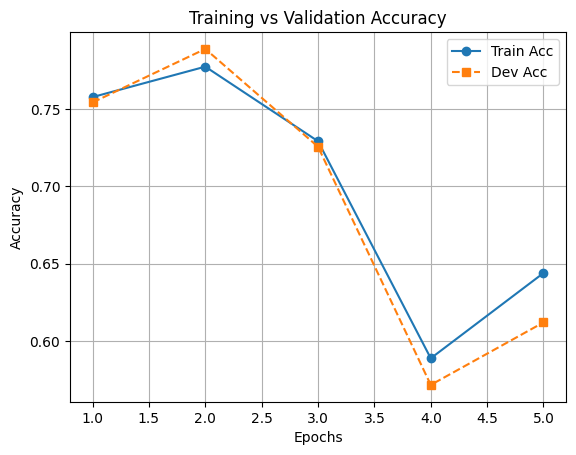


📊 Dev Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.60      0.74     28736
           1       0.14      0.74      0.23      2451

    accuracy                           0.61     31187
   macro avg       0.55      0.67      0.49     31187
weighted avg       0.90      0.61      0.70     31187


🔍 Predicting on test set...
📁 Saved to final_predictions.csv ✅


In [13]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt

train_df = pd.read_csv("/kaggle/input/preprocessed/preprocessed_train (1).csv")
dev_df = pd.read_csv("/kaggle/input/preprocessed/preprocessed_dev (1).csv")
test_df = pd.read_csv("/kaggle/input/test-data/test_data_SMM4H_2025_Task_1_no_labels.csv")

train_df['clean_text'] = train_df['clean_text'].fillna('')
dev_df['clean_text'] = dev_df['clean_text'].fillna('')
test_df['text'] = test_df['text'].fillna('')

# Load fast multilingual sentence transformer
print("🔄 Generating Sentence Embeddings...")
model = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

X_train = model.encode(train_df['clean_text'].tolist(), show_progress_bar=True, batch_size=64)
X_dev = model.encode(dev_df['clean_text'].tolist(), show_progress_bar=True, batch_size=64)
X_test = model.encode(test_df['text'].tolist(), show_progress_bar=True, batch_size=64)

y_train = train_df['label'].astype(int).values
y_dev = dev_df['label'].astype(int).values

# SVM model with early stopping
svm_model = SGDClassifier(loss="hinge", penalty="l2", alpha=0.0001, max_iter=1, tol=None, warm_start=True, class_weight="balanced")

train_acc_list, dev_acc_list = [], []
best_dev_acc = 0
patience, no_improve = 3, 0
epochs = 10

print("\n🚀 Training Model...")
for epoch in range(epochs):
    svm_model.fit(X_train, y_train)

    train_acc = accuracy_score(y_train, svm_model.predict(X_train))
    dev_acc = accuracy_score(y_dev, svm_model.predict(X_dev))

    train_acc_list.append(train_acc)
    dev_acc_list.append(dev_acc)

    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f}, Dev Acc = {dev_acc:.4f}")

    if dev_acc > best_dev_acc:
        best_dev_acc = dev_acc
        no_improve = 0
    else:
        no_improve += 1
    if no_improve >= patience:
        print(f"⏹️ Early stopping at epoch {epoch+1}")
        break

# Plot accuracy
plt.plot(range(1, len(train_acc_list)+1), train_acc_list, label='Train Acc', marker='o')
plt.plot(range(1, len(dev_acc_list)+1), dev_acc_list, label='Dev Acc', marker='s', linestyle='dashed')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid()
plt.show()

# Evaluate
y_pred_dev = svm_model.predict(X_dev)
print("\n📊 Dev Classification Report:")
print(classification_report(y_dev, y_pred_dev))

# ✅ Final test predictions
print("\n🔍 Predicting on 3test set...")
test_df["predicted_label"] = svm_model.predict(X_test)
test_df[["id", "predicted_label"]].to_csv("final_predictions.csv", index=False)
print("📁 Saved to final_predictions.csv ✅")

In [18]:
import pandas as pd
from sentence_transformers import SentenceTransformer

# Load test set
test_df = pd.read_csv('/kaggle/input/test-data/test_data_SMM4H_2025_Task_1_no_labels.csv')
test_df['text'] = test_df['text'].fillna('')

# Load sentence transformer (same as used in training)
embedder = SentenceTransformer('paraphrase-multilingual-MiniLM-L12-v2')

# Encode test text
print("🔄 Generating Sentence Embeddings for Test Set...")
X_test = embedder.encode(test_df['text'].tolist(), show_progress_bar=True, batch_size=64)

# Make sure your trained model is still in memory, else retrain or load it
# Predict
print("🔍 Predicting...")
test_df['predicted_label'] = svm_model.predict(X_test)

# Save predictions
test_df[['id', 'predicted_label']].to_csv("test_predictions.csv", index=False)
print("✅ Test predictions saved to final_predictions.csv")


🔄 Generating Sentence Embeddings for Test Set...


Batches:   0%|          | 0/363 [00:00<?, ?it/s]

🔍 Predicting...
✅ Test predictions saved to final_predictions.csv


In [ ]:
import joblib
svm_model = joblib.load("svm_model.pkl")
